In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Instalação das dependências e Imports

In [3]:
import pandas as pd

In [4]:
 from sklearn.preprocessing import LabelEncoder
 from sklearn.model_selection import train_test_split

In [5]:
#Utilizando o iob_transformer do Matheus Stauffer
!git clone -s https://github.com/mstauffer/tcdf_text_classification.git

Cloning into 'tcdf_text_classification'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 43 (delta 16), reused 30 (delta 8), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
from tcdf_text_classification.iob_transformer import iob_transformer

In [9]:
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [10]:
from gensim.models import Word2Vec

In [11]:
import tensorflow

In [12]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 10.7 MB/s 


In [13]:
from keras.models import Sequential
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, TimeDistributed, Bidirectional,GlobalMaxPooling1D
from livelossplot.tf_keras import PlotLossesCallback

In [25]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=08ff39e7732b484031ebf3b064f1108d46b1d11eb96bf9054a9c6a4856f6a595
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [26]:
from seqeval.metrics import f1_score, classification_report

In [45]:
from nltk.tokenize import word_tokenize

#Carregando o dataset

In [14]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/nido ner experiments/DODFCorpus_contratos_licitacoes_v1.csv')

df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis =1)


In [15]:
df

,id_dodf,tipo_rel,id_rel,anotador_rel,tipo_ent,id_ent,anotador_ent,offset,length,texto,id_ato
0,12_22.11.2018,REL_AVISO_LICITACAO,R21,anotador_50435513,modalidade_licitacao,1,anotador_50435513,432851,17,PREGAO ELETRONICO,12_22.11.2018-R21
1,12_22.11.2018,REL_AVISO_LICITACAO,R21,anotador_50435513,numero_licitacao,2,anotador_50435513,432872,8,116/2018,12_22.11.2018-R21
2,12_22.11.2018,REL_AVISO_LICITACAO,R21,anotador_50435513,valor_estimado_contratacao,6,anotador_50435513,433432,10,"767.907,37",12_22.11.2018-R21
3,12_22.11.2018,REL_AVISO_LICITACAO,R21,anotador_50435513,data_abertura_licitacao,7,anotador_50435513,433599,10,20/11/2018,12_22.11.2018-R21
4,12_22.11.2018,REL_AVISO_LICITACAO,R21,anotador_50435513,sistema_compras,8,anotador_50435513,433716,21,www.compras.df.gov.br,12_22.11.2018-R21
...,...,...,...,...,...,...,...,...,...,...,...
41039,638,REL_SUSPENSAO_LICITACAO,R7,anotador_14379604,processo_gdf,258,anotador_14379604,210132,22,04012-00000112/2022-79,638-R7
41040,638,REL_SUSPENSAO_LICITACAO,R7,anotador_14379604,orgao_licitante,255,anotador_14379604,210158,63,Secretaria de Estado de Trabalho do Distrito F...,638-R7
41041,638,REL_SUSPENSAO_LICITACAO,R7,anotador_14379604,objeto_licitacao,3902,anotador_14379604,210322,367,Registro de Preços para contratação de empresa...,638-R7
41042,638,REL_SUSPENSAO_LICITACAO,R7,anotador_14379604,orgao_licitante,3206,anotador_14379604,210631,58,Secretaria de Estado do Trabalho Distrito Fede...,638-R7


Observando a quantidade de tipos de ato, faz-se necessário separar os dados de treinamento e de teste de maneira igual para cada tipo de ato.

In [16]:
df.tipo_rel.value_counts()

REL_EXTRATO_CONTRATO        20750
REL_ADITAMENTO_CONTRATO     11796
REL_AVISO_LICITACAO          7413
REL_SUSPENSAO_LICITACAO       497
REL_ANUL_REVOG_LICITACAO      350
REL_EXTRATO_CONVENIO          238
Name: tipo_rel, dtype: int64

In [17]:
df.tipo_rel.unique()

array(['REL_AVISO_LICITACAO', 'REL_SUSPENSAO_LICITACAO',
       'REL_EXTRATO_CONTRATO', 'REL_ADITAMENTO_CONTRATO',
       'REL_EXTRATO_CONVENIO', 'REL_ANUL_REVOG_LICITACAO'], dtype=object)

#Extração dos IOBs

In [18]:
def split_data(dset):
  iob_v = iob_transformer('id_ato', 'texto', 'tipo_ent', keep_punctuation=True, return_df=False)

  acts, labels = iob_v.transform(dset)

  x_train, x_test, y_train, y_test = train_test_split(acts,labels, train_size=0.8, random_state=1)

  x_test, x_val, y_test, y_val = train_test_split(x_test,y_test, train_size=0.5, random_state=1)

  return x_train, y_train, x_test, y_test, x_val, y_val

In [19]:
train_acts = []
train_labels = []

test_acts = []
test_labels = []

val_acts = []
val_labels = []

aux = df.tipo_rel.unique()

for d in aux:
  q = "tipo_rel == " + "'" + str(d) + "'"
  tr_acts, tr_labels, te_acts, te_labels, v_acts, v_labels = split_data(df.query(q))

  train_acts.extend(tr_acts)
  train_labels.extend(tr_labels)

  test_acts.extend(te_acts)
  test_labels.extend(te_labels)

  val_acts.extend(v_acts)
  val_labels.extend(v_labels)



In [20]:
def remove_wrong_tags(label_list):
  for label in label_list:
    for idx,w in enumerate(label):
      if w in ['B-11','B-12','B-50']:
        label[idx] = 'O'

In [21]:
remove_wrong_tags(train_labels)
remove_wrong_tags(test_labels)
remove_wrong_tags(val_labels)

In [22]:
iob = iob_transformer('id_ato', 'texto', 'tipo_ent', keep_punctuation=True, return_df=False)

In [23]:
iob_data = iob_transformer('id_ato', 'texto', 'tipo_ent', keep_punctuation=True, return_df=True)

In [24]:
acts, labels = iob.transform(df)

In [27]:
remove_wrong_tags(labels)

In [28]:
df_iob = iob_data.transform(df)
df_iob

,Sentence_idx,Word,Tag
0,-1,UNK,O
1,0,AVISOS,O
2,0,DE,O
3,0,LICITACOES,O
4,0,PREGAO,B-modalidade_licitacao
...,...,...,...
834274,3849,.,O
834275,3849,JUNILMA,B-nome_responsavel
834276,3849,OLIVEIRA,I-nome_responsavel
834277,3849,FERREIRA,I-nome_responsavel


In [29]:
df_iob.loc[df_iob.Word == 'B-11','Tag']='O'
df_iob.loc[df_iob.Word == 'B-12','Tag']='O'
df_iob.loc[df_iob.Word == 'B-50','Tag']='O'

In [30]:
#salvando todas as palavras do corpus sem repetição
words = set()

for act in acts:
    for word in act:
        words.add(word)
#convertendo o set em uma lista
words = list(words)

words.append("ENDPAD")
words.append("UNK")

words_amt = len(words)

In [31]:
tags = set()

for label in labels:
    for tag in label:
        tags.add(tag)
tags = list(tags)
tags_amt = len(tags)

tags_amt

76

In [32]:
tags

['B-valor_estimado_contratacao',
 'I-unidade_orcamentaria',
 'B-modalidade_licitacao',
 'O',
 'B-nota_empenho',
 'I-orgao_concedente',
 'I-valor_estimado_contratacao',
 'B-sistema_compras',
 'B-cnpj_orgao_contratante',
 'I-tipo_objeto',
 'I-decisao_tcdf',
 'I-cnpj_entidade_contratada',
 'I-numero_termo_aditivo',
 'B-valor_convenio',
 'B-programa_trabalho',
 'I-orgao_licitante',
 'I-programa_trabalho',
 'B-cnpj_entidade_convenente',
 'I-numero_convenio',
 'B-orgao_licitante',
 'I-objeto_licitacao',
 'B-data_escrito',
 'B-codigo_licitacao_sistema_compras',
 'B-orgao_concedente',
 'I-objeto_contrato',
 'B-entidade_contratada',
 'I-sistema_compras',
 'I-data_assinatura_convenio',
 'B-numero_convenio',
 'B-tipo_objeto',
 'B-unidade_orcamentaria',
 'B-vigencia_contrato',
 'B-fonte_recurso',
 'B-numero_licitacao',
 'B-data_assinatura_contrato',
 'I-vigencia_contrato',
 'B-entidade_convenente',
 'B-identificacao_ocorrencia',
 'I-orgao_contratante',
 'B-numero_termo_aditivo',
 'I-nome_responsav

#Transformando os valores dos dados (representação inteira)

In [33]:
vocab = {}

for i in range(0,len(acts)):
    for word in acts[i]:
        if word.lower() not in vocab:
            vocab[word.lower()] = 1
        else:
            vocab[word.lower()]+=1

In [34]:
#dicionario das palavras com seu respectivo valor inteiro
lab_enc = LabelEncoder()

lab_enc.fit(words)
words_i = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))

i_words = {}

for key in words_i:
  i_words[words_i[key]] = key

#i_words

In [35]:
lab_enc = LabelEncoder()

lab_enc.fit(tags)
tags_i = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))


i_tags = {}

for key in tags_i:
  i_tags[tags_i[key]] = key

i_tags

{0: 'B-cnpj_entidade_contratada',
 1: 'B-cnpj_entidade_convenente',
 2: 'B-cnpj_orgao_concedente',
 3: 'B-cnpj_orgao_contratante',
 4: 'B-codigo_licitacao_sistema_compras',
 5: 'B-codigo_siggo',
 6: 'B-data_abertura_licitacao',
 7: 'B-data_assinatura_contrato',
 8: 'B-data_assinatura_convenio',
 9: 'B-data_escrito',
 10: 'B-decisao_tcdf',
 11: 'B-entidade_contratada',
 12: 'B-entidade_convenente',
 13: 'B-fonte_recurso',
 14: 'B-identificacao_ocorrencia',
 15: 'B-modalidade_licitacao',
 16: 'B-natureza_despesa',
 17: 'B-nome_responsavel',
 18: 'B-nota_empenho',
 19: 'B-numero_contrato',
 20: 'B-numero_convenio',
 21: 'B-numero_licitacao',
 22: 'B-numero_termo_aditivo',
 23: 'B-objeto_aditamento_contratual',
 24: 'B-objeto_contrato',
 25: 'B-objeto_convenio',
 26: 'B-objeto_licitacao',
 27: 'B-orgao_concedente',
 28: 'B-orgao_contratante',
 29: 'B-orgao_licitante',
 30: 'B-processo_gdf',
 31: 'B-programa_trabalho',
 32: 'B-sistema_compras',
 33: 'B-tipo_objeto',
 34: 'B-unidade_orcament

#Padding

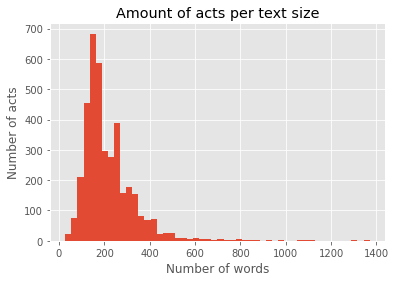

In [37]:
plt.hist([len(ato) for ato in acts], bins=50)

plt.xlabel("Number of words")
plt.ylabel("Number of acts")
plt.title("Amount of acts per text size")
plt.show()

In [38]:
def transform_data(x,y):
  X,Y = [],[]

  for act in x:
    aux = []
    for word in act:
      aux.append(words_i[word])
    X.append(aux)

  for label in y:
    aux = []
    for word in label:
      aux.append(tags_i[word])
    Y.append(aux)

  return X,Y

In [39]:
x_train,y_train = transform_data(train_acts,train_labels)

x_test, y_test = transform_data(test_acts,test_labels)

x_val, y_val = transform_data(val_acts,val_labels)


In [40]:
x_train = pad_sequences(maxlen=450, sequences=x_train, padding="post", value=words_i['ENDPAD'])
x_test = pad_sequences(maxlen=450, sequences=x_test, padding="post", value=words_i['ENDPAD'])
x_val = pad_sequences(maxlen=450, sequences=x_val, padding="post", value=words_i['ENDPAD'])

y_train = pad_sequences(maxlen=450, sequences=y_train, padding="post", value=tags_i["O"])
y_test = pad_sequences(maxlen=450, sequences=y_test, padding="post", value=tags_i["O"])
y_val = pad_sequences(maxlen=450, sequences=y_val, padding="post", value=tags_i["O"])

#Modelos

##Word Embbeding (word2vec)

In [41]:
df2 =  pd.read_csv('/content/drive/MyDrive/nido ner experiments/dodf_atos_pessoal_final_version.csv')

In [43]:
l = [df2["texto_rel"]]
headers = ["texto"]
df_emb = pd.concat(l, axis=1, keys=headers)

In [44]:
df_emb.drop_duplicates(subset=['texto'],inplace=True)

In [46]:
t_aux = list(df_emb["texto"])
text = []

for sent in t_aux:
  ap = sent.lower()
  ap = word_tokenize(ap)
  text.append(ap)

#text

In [47]:
model_emb = Word2Vec(min_count=1, window=5)
model_emb.build_vocab(text)  
model_emb.train(text, total_examples=model_emb.corpus_count, epochs=model_emb.epochs)

(1864482, 3169395)

In [48]:
word_vectors = model_emb.wv

In [49]:
print(len(word_vectors[0]))

100


In [50]:
emb_dim = len(word_vectors[0])

In [51]:
emb_mtx = np.zeros((words_amt, emb_dim))

In [52]:
for word, i in words_i.items():
    if word in word_vectors:
        emb_vec = word_vectors[word]
        emb_mtx[i] = emb_vec
    else:
        emb_mtx[i] = np.random.normal(0,1,emb_dim)

In [53]:
from keras.layers import Embedding
from tensorflow import keras

In [54]:
embedding_layer = Embedding(words_amt,
                            emb_dim,
                            embeddings_initializer=keras.initializers.Constant(emb_mtx),
                            input_length=450,
                            trainable=False)

##word2vec-LSTM

In [58]:
tensorflow.keras.backend.clear_session()

In [59]:
model  = Sequential()
model.add(embedding_layer)
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(Dense(tags_amt, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 450, 100)          4009300   
                                                                 
 lstm (LSTM)                 (None, 450, 100)          80400     
                                                                 
 dropout (Dropout)           (None, 450, 100)          0         
                                                                 
 dense (Dense)               (None, 450, 76)           7676      
                                                                 
Total params: 4,097,376
Trainable params: 88,076
Non-trainable params: 4,009,300
_________________________________________________________________


In [71]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

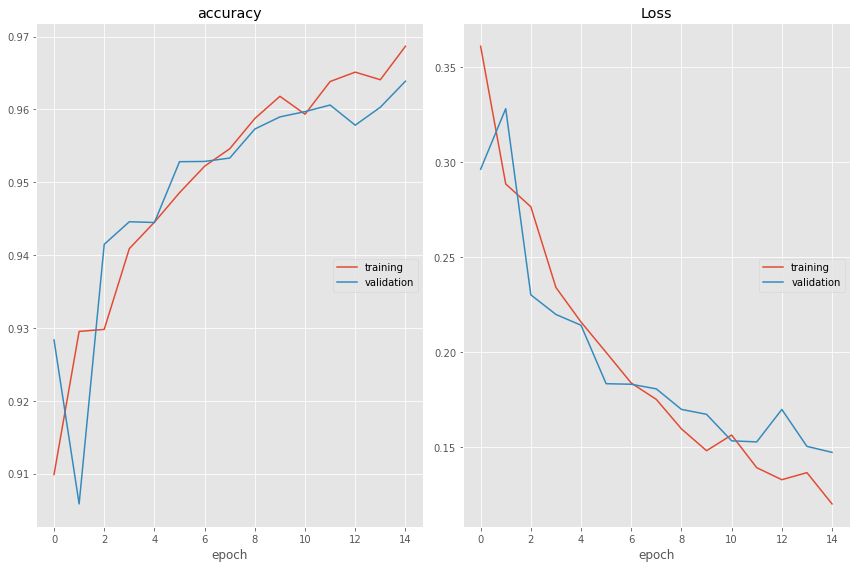

accuracy
	training         	 (min:    0.910, max:    0.969, cur:    0.969)
	validation       	 (min:    0.906, max:    0.964, cur:    0.964)
Loss
	training         	 (min:    0.120, max:    0.361, cur:    0.120)
	validation       	 (min:    0.147, max:    0.328, cur:    0.147)
103/103 [==============================] - 3s 24ms/step - loss: 0.1203 - accuracy: 0.9687 - val_loss: 0.1474 - val_accuracy: 0.9639


In [72]:
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=30, epochs=15,callbacks=[PlotLossesCallback()])

In [73]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 23ms/step - loss: 0.1684 - accuracy: 0.9598


[0.16836810111999512, 0.9598445892333984]

Avaliação do word2vec-LSTM

In [74]:
y_pred_m1 = model.predict(x_test, batch_size=30)

In [75]:
index_array = np.argmax(y_pred_m1, axis=-1)

In [76]:
def convert_values(index_array,y_test):
  pred_tags = []
  real_tags = []

  for act in index_array:
    act_tags = []
    for w in act:
      act_tags.append(i_tags[w])
    pred_tags.append(act_tags)

  for ato in y_test:
    tags_ato = []
    for palavra in ato:
      tags_ato.append(i_tags[palavra])
    real_tags.append(tags_ato)

  return real_tags, pred_tags

In [77]:
real_tags, pred_tags = convert_values(index_array,y_test)
f1_score(real_tags, pred_tags)

0.60408042578356

In [78]:
print(classification_report(real_tags, pred_tags))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                  precision    recall  f1-score   support

        cnpj_entidade_contratada       1.00      0.32      0.49        34
        cnpj_entidade_convenente       0.00      0.00      0.00         1
          cnpj_orgao_contratante       0.00      0.00      0.00        12
codigo_licitacao_sistema_compras       0.97      0.80      0.88        44
                    codigo_siggo       0.00      0.00      0.00        34
         data_abertura_licitacao       0.08      0.02      0.03        65
        data_assinatura_contrato       0.90      0.72      0.80        86
        data_assinatura_convenio       0.00      0.00      0.00         2
                    data_escrito       0.84      0.53      0.65       154
                    decisao_tcdf       0.00      0.00      0.00         1
             entidade_contratada       0.30      0.36      0.33       161
             entidade_convenente       0.00      0.00      0.00         4
                   fonte_recurso     

##CNN-LSTM

In [79]:
model2 = Sequential()
model2.add(Embedding(input_dim=words_amt+1, output_dim=50, input_length=450))
model2.add(Conv1D(filters=tags_amt, kernel_size=3, padding='same', activation='relu'))
model2.add(LSTM(100, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(Dense(tags_amt, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 450, 50)           2004700   
                                                                 
 conv1d (Conv1D)             (None, 450, 76)           11476     
                                                                 
 lstm_1 (LSTM)               (None, 450, 100)          70800     
                                                                 
 dropout_1 (Dropout)         (None, 450, 100)          0         
                                                                 
 dense_1 (Dense)             (None, 450, 76)           7676      
                                                                 
Total params: 2,094,652
Trainable params: 2,094,652
Non-trainable params: 0
_________________________________________________________________


In [80]:
model2.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

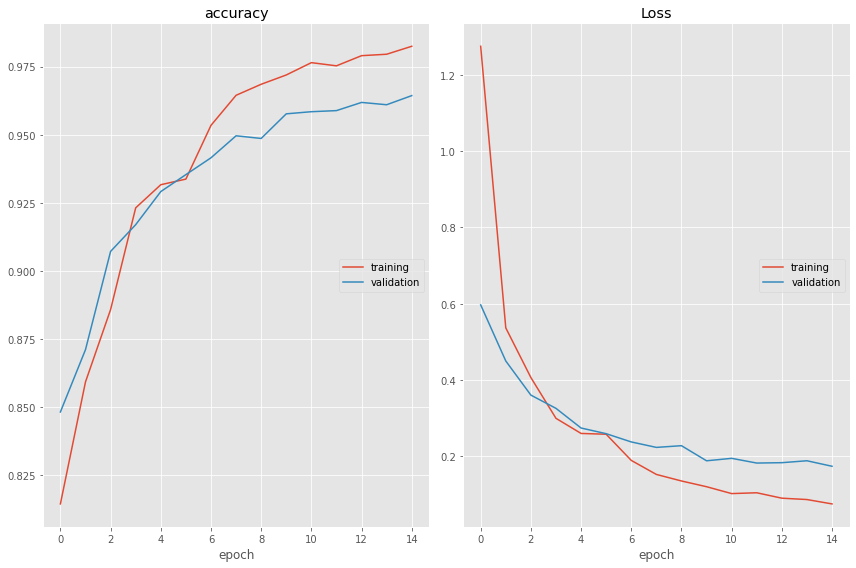

accuracy
	training         	 (min:    0.815, max:    0.982, cur:    0.982)
	validation       	 (min:    0.848, max:    0.964, cur:    0.964)
Loss
	training         	 (min:    0.076, max:    1.275, cur:    0.076)
	validation       	 (min:    0.174, max:    0.597, cur:    0.174)
103/103 [==============================] - 3s 26ms/step - loss: 0.0757 - accuracy: 0.9825 - val_loss: 0.1743 - val_accuracy: 0.9644


In [81]:
history2 = model2.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=30, epochs=15, callbacks = [PlotLossesCallback()])

Avaliação do CNN-LSTM

In [82]:
y_pred_m2 = model2.predict(x_test, batch_size=30)

In [83]:
index_array = np.argmax(y_pred_m2, axis=-1)

In [84]:
real_tags, pred_tags = convert_values(index_array,y_test)
f1_score(real_tags, pred_tags)

0.5612407595303667

In [85]:
print(classification_report(real_tags, pred_tags))

                                  precision    recall  f1-score   support

        cnpj_entidade_contratada       1.00      0.15      0.26        34
        cnpj_entidade_convenente       0.00      0.00      0.00         1
          cnpj_orgao_contratante       0.00      0.00      0.00        12
codigo_licitacao_sistema_compras       0.93      0.59      0.72        44
                    codigo_siggo       0.00      0.00      0.00        34
         data_abertura_licitacao       0.57      0.31      0.40        65
        data_assinatura_contrato       0.83      0.47      0.60        86
        data_assinatura_convenio       0.00      0.00      0.00         2
                    data_escrito       0.79      0.41      0.54       154
                    decisao_tcdf       0.00      0.00      0.00         1
             entidade_contratada       0.23      0.25      0.24       161
             entidade_convenente       0.00      0.00      0.00         4
                   fonte_recurso     

##CNN-BiLSTM

In [86]:
model3 = Sequential()
model3.add(Embedding(input_dim=words_amt+1, output_dim=50, input_length=450))
model3.add(Conv1D(filters=tags_amt, kernel_size=3, padding='same', activation='relu'))
model3.add(Bidirectional(LSTM(100, return_sequences=True)))
model3.add(Dropout(0.5))
model3.add(Dense(tags_amt, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 450, 50)           2004700   
                                                                 
 conv1d_1 (Conv1D)           (None, 450, 76)           11476     
                                                                 
 bidirectional (Bidirectiona  (None, 450, 200)         141600    
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 450, 200)          0         
                                                                 
 dense_2 (Dense)             (None, 450, 76)           15276     
                                                                 
Total params: 2,173,052
Trainable params: 2,173,052
Non-trainable params: 0
____________________________________________

In [87]:
model3.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

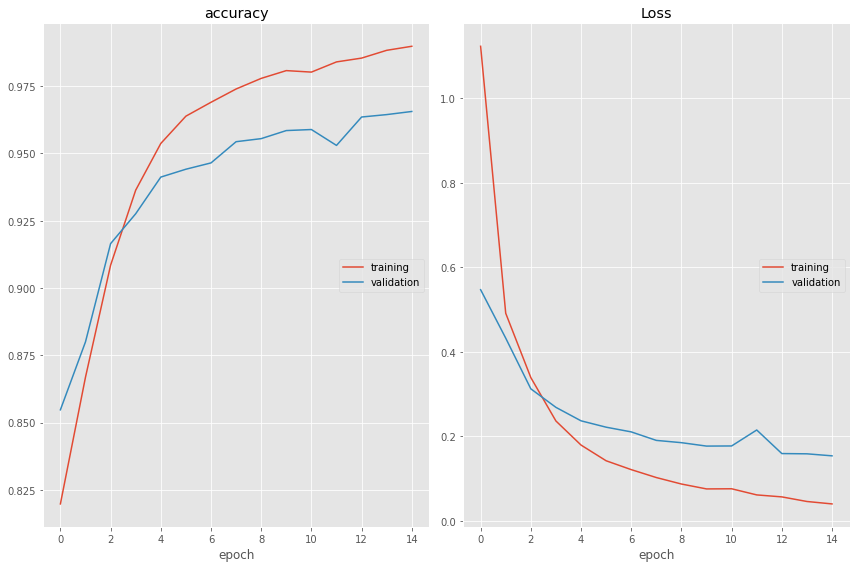

accuracy
	training         	 (min:    0.820, max:    0.990, cur:    0.990)
	validation       	 (min:    0.855, max:    0.966, cur:    0.966)
Loss
	training         	 (min:    0.040, max:    1.123, cur:    0.040)
	validation       	 (min:    0.154, max:    0.547, cur:    0.154)
103/103 [==============================] - 4s 43ms/step - loss: 0.0405 - accuracy: 0.9898 - val_loss: 0.1542 - val_accuracy: 0.9656


In [88]:
history3 = model3.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=30, epochs=15, callbacks=[PlotLossesCallback()])

Avaliação CNN-BiLSTM

In [89]:
y_pred_m3 = model3.predict(x_test, batch_size=30)

In [90]:
index_array = np.argmax(y_pred_m3, axis=-1)

In [91]:
real_tags, pred_tags = convert_values(index_array,y_test)
f1_score(real_tags, pred_tags)

0.6632709251101322

In [92]:
print(classification_report(real_tags, pred_tags))

                                  precision    recall  f1-score   support

        cnpj_entidade_contratada       0.90      0.53      0.67        34
        cnpj_entidade_convenente       0.00      0.00      0.00         1
          cnpj_orgao_contratante       0.00      0.00      0.00        12
codigo_licitacao_sistema_compras       0.87      0.91      0.89        44
                    codigo_siggo       0.62      0.15      0.24        34
         data_abertura_licitacao       0.71      0.80      0.75        65
        data_assinatura_contrato       0.72      0.67      0.69        86
        data_assinatura_convenio       0.00      0.00      0.00         2
                    data_escrito       0.72      0.66      0.68       154
                    decisao_tcdf       0.00      0.00      0.00         1
             entidade_contratada       0.31      0.34      0.32       161
             entidade_convenente       0.00      0.00      0.00         4
                   fonte_recurso     